### main.py 테스트

* multi-turn 형식

In [37]:
import uuid, os
from dotenv import load_dotenv
from typing import TypedDict
from typing import Annotated

from openai import OpenAI
from langchain_openai import ChatOpenAI
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_teddynote.messages import random_uuid   # type: ignore
## langsmith
from langsmith import Client
from langchain_teddynote import logging
from langchain_core.tracers.context import collect_runs

from langgraph.graph import END, StateGraph # type: ignore
from langgraph.checkpoint.memory import MemorySaver # type: ignore
from langgraph.errors import GraphRecursionError # type: ignore

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig  

from langchain_community.chat_message_histories import ChatMessageHistory, StreamlitChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.graph.message import add_messages
from operator import itemgetter

from langchain.agents import tool
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

## Flask
from flask import Flask, request, jsonify, g, session
from flask_restx import Api, Resource
from flask_cors import CORS

from langchain_teddynote import logging

# .env 파일 활성화 & API KEY 설정
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
logging.langsmith("rag_chatbot_test")

llm_4o = ChatOpenAI(model="gpt-4o", temperature=0)

class GraphState(TypedDict):
    question: str # 질문
    q_type: str  # 질문의 유형
    context: list | str  # 문서의 검색 결과
    answer: str | list[str]   # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)
    # chat_history: str  # 채팅 히스토리
    
store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환

#######################################################################
############################ nodes: Router ############################
#######################################################################

# 자료구조 정의 (pydantic)
class Router(BaseModel):
    type: str = Field(description="type of the query that model choose")

# 출력 파서 정의
router_output_parser = JsonOutputParser(pydantic_object=Router)
format_instructions = router_output_parser.get_format_instructions()

# prompt 구성
router_prompt = PromptTemplate(
    template="""
            You are an expert who classifies the type of question. There are two query types: [‘general’, ‘domain_specific’]

            [general]
            Questions unrelated to addresses, such as translating English to Korean, asking for general knowledge (e.g., “What is the capital of South Korea?”), or queries that can be answered through a web search.

            [domain_specific]
            Questions related to addresses, such as concepts, definitions, address-related data analysis, or reviewing properly written addresses (e.g., “수지구는 자치구이니 일반구이니?”, “특별시에 대해서 설명해줘”, “주소와 주소정보의 차이점은?”).

            <Output format>: Always respond with either “general” or “domain_specific” and nothing else. {format_instructions}
            <chat_history>: {chat_history}
            
            <Question>: {query} 
            """,
    input_variables=["query", "chat_history"],
    partial_variables={"format_instructions": format_instructions},
)

def router(state: GraphState) -> GraphState:
    chain = router_prompt | llm_4o | router_output_parser
    
    router_with_history  = RunnableWithMessageHistory(
        chain,
        get_session_history,  # 세션 기록을 가져오는 함수
        input_messages_key="query",  # 사용자의 질문이 템플릿 변수에 들어갈 key
        history_messages_key="chat_history",  # 기록 메시지의 키
    )
    
    router_result = router_with_history.invoke({"query": state["question"]})
    state["q_type"] = router_result['type']
    return state

def router_conditional_edge(state: GraphState) -> GraphState:
    q_type = state["q_type"].strip()
    return q_type

##################################################################################
############################ nodes: Retrieve Document ############################
##################################################################################

client = chromadb.PersistentClient('chroma/')
embedding = OpenAIEmbeddings(model='text-embedding-3-large')  
vectorstore = Chroma(client=client, collection_name="49_files_openai_3072", embedding_function=embedding)

def retrieve_document(state: GraphState) -> GraphState:
    retrieved_docs = vectorstore.similarity_search_with_score(state["question"], k=3)
    return {**state, "context": retrieved_docs} 

#########################################################################
############################ nodes: Verifier ############################
#########################################################################

# 자료구조 정의 (pydantic)
class Verifier(BaseModel):
    type: str = Field(description="verify that retrieved data is sufficient to answer the query")

# 출력 파서 정의
verifier_output_parser = JsonOutputParser(pydantic_object=Verifier)
format_instructions = verifier_output_parser.get_format_instructions()

verifier_prompt = PromptTemplate(
    template="""
            You are an expert who verity the retrieved data's quality and usefullness to answer the query. There are two query types: [‘sufficient’, ‘insufficient’, 'unsuitable']

            [sufficient]
            When the retrieved data is sufficient to answer the query.
            
            [insufficient]
            When the retrieved data is insufficient to answer the query, triggering additional actions or tool usage:
            1.	When the context information is inadequate to respond to the query, requiring further steps (e.g., search).
            2.	When the query involves tasks beyond simple address-related information retrieval, such as report generation or image creation.

            [unsuitable]
            When the retrieved data is not suitable to answer the query.
            
            <Output format>: Always respond with either "sufficient", "insufficient" or "unsuitable" and nothing else. {format_instructions}
            
            <Question>: {query} 
            <Retrieved data>: {retrieved_data}
            """,
    input_variables=["query", "retrieved_data"],
    partial_variables={"format_instructions": format_instructions},
)

def verifier(state: GraphState) -> GraphState:
    chain = verifier_prompt | llm_4o | verifier_output_parser
    verified = chain.invoke({"query": state["question"], "retrieved_data": state["context"]})
    state["relevance"] = verified['type']
    return state

def verifier_conditional_edge(state: GraphState) -> str:
    verified_result = state["relevance"].strip()
    
    if verified_result not in ["sufficient", "insufficient", "unsuitable"]:
        raise ValueError(f"Unexpected verifier result: {verified_result}")

    return verified_result
 
 ############################ tools ############################

@tool
def search_on_web(input):
    """ 실시간 정보, 최신 정보 등 웹 검색이 필요한 질문에 답변하기 위해 사용하는 도구 """
    search_tool = TavilySearchResults(max_results=5)
    search_result = search_tool.invoke({"query": input})

    return search_result

@tool
def image_generator(input):
    """ 이미지 생성기 """
    client = OpenAI()
    response = client.images.generate(
        model="dall-e-3",
        prompt=input,
        size="1024x1024",
        quality="standard",
        n=1,
    )
    
    image_url = response.data[0].url
    return image_url

@tool
def advanced_assistant(input, retrieved_data):
    """ 고급 기능(예: 긴 문서 생성, 추론이 필요한 답변 등)을 수행할 수 있는 모델 """
    client = OpenAI()
 
    response = client.chat.completions.create(
        model="o1",
        messages=[
            { "role": "developer", "content": "You are a helpful assistant." },
            {
                "role": "user", 
                "content": input
            }
        ]
    )
    
    result = response.choices[0].message.content
    return result

@tool
def image_explainer(query, image_url):
    """ 이미지 설명 생성기. Use after the image_generator tool make the image output. Use the url of the image_generator tool. """
    client = OpenAI()  # Client 객체 생성

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": query},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": image_url,
                        },
                    },
                ],
            }
        ],
        max_tokens=300,
    )
    return response.choices[0]
    

tools = [search_on_web, image_generator, advanced_assistant, image_explainer]

agent_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a helpful assistant, and you use Korean.
            Make sure to use the appropriate tools for the task when `relevance` is `insufficient` or `unsuitable`.
            If relevance is `sufficient`, you can directly provide the answer.
            1.	You can appropriately select and use various tools based on the situation.
                (Note) When the user asks for current information, consider “February 2025” as the reference point for up-to-date data.
            2.	If the relevance is “insufficient,” use the retrieved_data along with the search_on_web tool.
            3.	If you use the advanced_assistant tool, make sure to reflect both the content and the full extent of the response in your final answer.
            4.	If you use the image_generator tool, you must also use the image_explainer tool to provide a description of the generated image.
            5.	(IMPORTANT) The user may have multiple requests, and you must generate a response that addresses all of them.
                - If multiple tools are required to fulfill different aspects of the user’s request, combine the results comprehensively into a single, final response.
                - If an image is generated, you must include both the image URL and a detailed explanation of the image.
                - Ensure that all tool outputs are fully incorporated into the final answer.
            """
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

def agent(state: GraphState) -> GraphState:
    
    agent = create_tool_calling_agent(llm_4o, tools, agent_prompt)
    
    agent_executor = AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=False,
        max_iterations=100,
        max_execution_time=100,
        handle_parsing_errors=True,
        return_intermediate_steps=True
    )
    
    tool_input = {"input": state["question"], "retrieved_data": state["context"], "relevance": state["relevance"]}


    agent_with_history = RunnableWithMessageHistory(
        agent_executor,
        get_session_history,  # 세션 기록을 가져오는 함수
        input_messages_key="input",  # 사용자의 질문이 템플릿 변수에 들어갈 key
        history_messages_key="chat_history",  # 기록 메시지의 키
    )


    result = agent_with_history.invoke({"input": state["question"], "retrieved_data": state["context"], "relevance": state["relevance"]})
    state['answer'] = result['output']

    return state

########################################################################
############################ Workflow Graph ############################
########################################################################

workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("Router", router)  # 질문의 종류를 분류하는 노드를 추가합니다.
workflow.add_node("Retrieved Data", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
workflow.add_node("Agent", agent)  # 일반 질문에 대한 답변을 생성하는 노드를 추가합니다.
workflow.add_node("Verifier", verifier)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
# workflow.add_node("llm_answer", llm_model)  # 답변을 생성하는 노드를 추가합니다.

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "Router",  # 질문의 종류를 분류하는 노드에서 나온 결과를 기반으로 다음 노드를 선택합니다.
    router_conditional_edge,
    {"domain_specific": "Retrieved Data",  "general": "Agent"},
)

workflow.add_edge("Retrieved Data", "Verifier")  # 검색 -> 답변
workflow.add_edge("Verifier", "Agent")  # 답변 -> 답변

workflow.add_edge("Agent", END)  # 답변 -> 종료

# 시작점을 설정합니다.
workflow.set_entry_point("Router")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
graph = workflow.compile(checkpointer=memory)    

LangSmith 추적을 시작합니다.
[프로젝트명]
rag_chatbot_test


In [38]:
config = RunnableConfig(recursion_limit=20, configurable={"session_id": "1", "thread_id": uuid.uuid4().hex})  

question = (
    "내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요"
)

inputs = GraphState(
    question=question,
    )

answer = graph.invoke(inputs, config=config)
answer

{'question': '내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요',
 'q_type': 'general',
 'context': None,
 'answer': '안녕하세요, 테디노트님! 만나서 반갑습니다. YouTube 채널을 운영하고 계시다니 정말 멋지네요. 채널에서 어떤 콘텐츠를 다루고 계신가요? 도움이 필요하시면 언제든지 말씀해 주세요!',
 'relevance': None}

In [29]:
question = (
    "내 이름이 뭐라고 했어요?"
)

inputs = GraphState(
    question=question,
    )

answer = graph.invoke(inputs, config=config)
answer

Error in RootListenersTracer.on_chain_end callback: ValueError("Expected str, BaseMessage, List[BaseMessage], or Tuple[BaseMessage]. Got {'input': '내 이름이 뭐라고 했어요?', 'retrieved_data': None, 'relevance': None, 'chat_history': operator.itemgetter('chat_history')}.")


{'question': '내 이름이 뭐라고 했어요?',
 'q_type': 'general',
 'context': None,
 'answer': '당신의 이름은 "테디노트"라고 하셨습니다. YouTube 채널을 운영하고 계시다고 하셨네요. 만나서 반갑습니다!',
 'relevance': None,
 'chat_history': None}

In [6]:
# pip install grandalf
print(graph.get_graph().draw_ascii())

              +-----------+       
              | __start__ |       
              +-----------+       
                     *            
                     *            
                     *            
                +--------+        
                | Router |        
                +--------+        
              ...         ...     
             .               .    
           ..                 ... 
+----------------+               .
| Retrieved Data |               .
+----------------+               .
         *                       .
         *                       .
         *                       .
   +----------+                  .
   | Verifier |               ... 
   +----------+              .    
              ***         ...     
                 *       .        
                  **   ..         
                +-------+         
                | Agent |         
                +-------+         
                     *            
                    

In [7]:
mermaid_code = graph.get_graph().draw_mermaid()
mermaid_code = mermaid_code.replace("&nbsp;", " ")  # 공백으로 변환
print(mermaid_code)

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	__end__([<p>__end__</p>]):::last
	Router(Router)
	Retrieved_Data(Retrieved Data)
	Agent(Agent)
	Verifier(Verifier)
	Agent --> __end__;
	Retrieved_Data --> Verifier;
	Verifier --> Agent;
	__start__ --> Router;
	Router -.  domain_specific  .-> Retrieved_Data;
	Router -.  general  .-> Agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



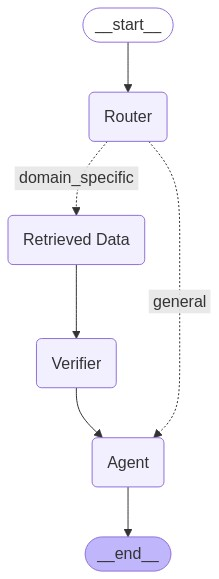

In [8]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid.uuid4().hex})  

question = (
    "내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요"
)

inputs = GraphState(
    question=question,
    )

answer = graph.invoke(inputs, config=config)
answer

{'question': [HumanMessage(content='내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요', id='1e61d3ed-c3ab-4fae-8836-67c470cba72f')],
 'q_type': 'general',
 'context': [],
 'answer': '안녕하세요, 테디노트님! YouTube 채널을 운영하신다니 정말 멋지네요. 만나서 반갑습니다. 채널 운영에 대해 궁금한 점이나 도움이 필요하시면 언제든지 말씀해 주세요!',
 'relevance': ''}

In [11]:
question = (
    "내 이름이 뭐라고 했어요?"
)

inputs = GraphState(
    question=question,
    )

answer = graph.invoke(inputs, config=config)
answer

{'question': [HumanMessage(content='내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요', id='1e61d3ed-c3ab-4fae-8836-67c470cba72f'),
  HumanMessage(content='내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요', id='d7844d9b-c569-4a02-97ec-65560a1c34be'),
  HumanMessage(content='내 이름이 뭐라고 했어요?', id='84c6f27c-4f1d-4da1-855d-8daa176d65cc')],
 'q_type': 'general',
 'context': [],
 'answer': '당신의 이름은 "테디노트"입니다. YouTube 채널을 운영하고 계시다고 하셨습니다. 만나서 반갑습니다!',
 'relevance': ''}

### wikidocs 예제 테스트

In [25]:
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing import Literal, Sequence, Optional, List
import json
import os


class TavilySearchInput(BaseModel):
    """Input for the Tavily tool."""

    query: str = Field(description="검색 쿼리")


def format_search_result(result: dict, include_raw_content: bool = False) -> str:
    """
    Utility functions for formatting search results.

    Args:
        result (dict): 원본 검색 결과

    Returns:
        str: XML 형식으로 포맷팅된 검색 결과
    """
    # 한글 인코딩 처리를 위해 json.dumps() 사용
    title = json.dumps(result["title"], ensure_ascii=False)[1:-1]
    content = json.dumps(result["content"], ensure_ascii=False)[1:-1]
    raw_content = ""
    if (
        include_raw_content
        and "raw_content" in result
        and result["raw_content"] is not None
        and len(result["raw_content"].strip()) > 0
    ):
        raw_content = f"<raw>{result['raw_content']}</raw>"

    return f"<document><title>{title}</title><url>{result['url']}</url><content>{content}</content>{raw_content}</document>"


class TavilySearch(BaseTool):
    """
    Tool that queries the Tavily Search API and gets back json
    """

    name: str = "tavily_web_search"
    description: str = (
        "A search engine optimized for comprehensive, accurate, and trusted results. "
        "Useful for when you need to answer questions about current events. "
        "Input should be a search query. [IMPORTANT] Input(query) should be over 5 characters."
    )
    args_schema: type[BaseModel] = TavilySearchInput
    client: TavilyClient = None
    include_domains: list = []
    exclude_domains: list = []
    max_results: int = 3
    topic: Literal["general", "news"] = "general"
    days: int = 3
    search_depth: Literal["basic", "advanced"] = "basic"
    include_answer: bool = False
    include_raw_content: bool = True
    include_images: bool = False
    format_output: bool = False

    def __init__(
        self,
        api_key: Optional[str] = None,
        include_domains: list = [],
        exclude_domains: list = [],
        max_results: int = 3,
        topic: Literal["general", "news"] = "general",
        days: int = 3,
        search_depth: Literal["basic", "advanced"] = "basic",
        include_answer: bool = False,
        include_raw_content: bool = True,
        include_images: bool = False,
        format_output: bool = False,
    ):
        """
        TavilySearch 클래스의 인스턴스를 초기화합니다.

        Args:
            api_key (str): Tavily API 키
            include_domains (list): 검색에 포함할 도메인 목록
            exclude_domains (list): 검색에서 제외할 도메인 목록
            max_results (int): 기본 검색 결과 수
        """
        super().__init__()
        if api_key is None:
            api_key = os.environ.get("TAVILY_API_KEY", None)

        if api_key is None:
            raise ValueError("Tavily API key is not set.")

        self.client = TavilyClient(api_key=api_key)
        self.include_domains = include_domains
        self.exclude_domains = exclude_domains
        self.max_results = max_results
        self.topic = topic
        self.days = days
        self.search_depth = search_depth
        self.include_answer = include_answer
        self.include_raw_content = include_raw_content
        self.include_images = include_images
        self.format_output = format_output

    def _run(self, query: str) -> str:
        """BaseTool의 _run 메서드 구현"""
        results = self.search(query)
        return results
        # return json.dumps(results, ensure_ascii=False)

    def search(
        self,
        query: str,
        search_depth: Literal["basic", "advanced"] = None,
        topic: Literal["general", "news"] = None,
        days: int = None,
        max_results: int = None,
        include_domains: Sequence[str] = None,
        exclude_domains: Sequence[str] = None,
        include_answer: bool = None,
        include_raw_content: bool = None,
        include_images: bool = None,
        format_output: bool = None,
        **kwargs,
    ) -> list:
        """
        검색을 수행하고 결과를 반환합니다.

        Args:
            query (str): 검색 쿼리
            search_depth (str): 검색 깊이 ("basic" 또는 "advanced")
            topic (str): 검색 주제 ("general" 또는 "news")
            days (int): 검색할 날짜 범위
            max_results (int): 최대 검색 결과 수
            include_domains (list): 검색에 포함할 도메인 목록
            exclude_domains (list): 검색에서 제외할 도메인 목록
            include_answer (bool): 답변 포함 여부
            include_raw_content (bool): 원본 콘텐츠 포함 여부
            include_images (bool): 이미지 포함 여부
            format_output (bool): 결과를 포맷팅할지 여부
            **kwargs: 추가 키워드 인자

        Returns:
            list: 검색 결과 목록
        """
        # 기본값 설정
        params = {
            "query": query,
            "search_depth": search_depth or self.search_depth,
            "topic": topic or self.topic,
            "max_results": max_results or self.max_results,
            "include_domains": include_domains or self.include_domains,
            "exclude_domains": exclude_domains or self.exclude_domains,
            "include_answer": (
                include_answer if include_answer is not None else self.include_answer
            ),
            "include_raw_content": (
                include_raw_content
                if include_raw_content is not None
                else self.include_raw_content
            ),
            "include_images": (
                include_images if include_images is not None else self.include_images
            ),
            **kwargs,
        }

        # days 파라미터 처리
        if days is not None:
            if params["topic"] == "general":
                print(
                    "Warning: days parameter is ignored for 'general' topic search. Set topic parameter to 'news' to use days."
                )
            else:
                params["days"] = days

        # API 호출
        response = self.client.search(**params)

        # 결과 포맷팅
        format_output = (
            format_output if format_output is not None else self.format_output
        )
        if format_output:
            return [
                format_search_result(r, params["include_raw_content"])
                for r in response["results"]
            ]
        else:
            return response["results"]

    def get_search_context(
        self,
        query: str,
        search_depth: Literal["basic", "advanced"] = "basic",
        topic: Literal["general", "news"] = "general",
        days: int = 3,
        max_results: int = 5,
        include_domains: Sequence[str] = None,
        exclude_domains: Sequence[str] = None,
        max_tokens: int = 4000,
        format_output: bool = True,
        **kwargs,
    ) -> str:
        """
        검색 쿼리에 대한 컨텍스트를 가져옵니다. 웹사이트에서 관련 콘텐츠만 가져오는 데 유용하며,
        컨텍스트 추출과 제한을 직접 처리할 필요가 없습니다.

        Args:
            query (str): 검색 쿼리
            search_depth (str): 검색 깊이 ("basic" 또는 "advanced")
            topic (str): 검색 주제 ("general" 또는 "news")
            days (int): 검색할 날짜 범위
            max_results (int): 최대 검색 결과 수
            include_domains (list): 검색에 포함할 도메인 목록
            exclude_domains (list): 검색에서 제외할 도메인 목록
            max_tokens (int): 반환할 최대 토큰 수 (openai 토큰 계산 기준). 기본값은 4000입니다.
            format_output (bool): 결과를 포맷팅할지 여부
            **kwargs: 추가 키워드 인자

        Returns:
            str: 컨텍스트 제한까지의 검색 컨텍스트를 포함하는 JSON 문자열
        """
        response = self.client.search(
            query,
            search_depth=search_depth,
            topic=topic,
            days=days,
            max_results=max_results,
            include_domains=include_domains,
            exclude_domains=exclude_domains,
            include_answer=False,
            include_raw_content=False,
            include_images=False,
            **kwargs,
        )

        sources = response.get("results", [])
        if format_output:
            context = [
                format_search_result(source, include_raw_content=False)
                for source in sources
            ]
        else:
            context = [
                {
                    "url": source["url"],
                    "content": json.dumps(
                        {"title": source["title"], "content": source["content"]},
                        ensure_ascii=False,
                    ),
                }
                for source in sources
            ]

        # max_tokens 처리 로직은 여기에 구현해야 합니다.
        # 현재는 간단히 모든 컨텍스트를 반환합니다.
        return json.dumps(context, ensure_ascii=False)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
# from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)
tools = [tool]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[tool])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

memory = MemorySaver()

# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

# 첫 질문
question = (
    "내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요"
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

# 이어지는 질문
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()


In [27]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)


In [28]:
# 첫 질문
question = (
    "내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요"
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()


================================== Ai Message ==================================

안녕하세요, 테디노트님! 만나서 반갑습니다. YouTube 채널에 대해 이야기해 주실 수 있나요? 어떤 콘텐츠를 다루고 계신가요?


In [29]:
# 이어지는 질문
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()


================================== Ai Message ==================================

당신의 이름은 테디노트입니다.


In [31]:
answer = graph.invoke({"messages": [("user", question)]}, config=config)
answer

{'messages': [HumanMessage(content='내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요', id='2497ffcf-834d-4f5f-95f6-c5799483f0eb'),
  AIMessage(content='안녕하세요, 테디노트님! 만나서 반갑습니다. YouTube 채널에 대해 이야기해 주실 수 있나요? 어떤 콘텐츠를 다루고 계신가요?', response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 118, 'total_tokens': 160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-ea09b2f0-c6c0-4555-82b7-6e77c033d6b1-0', usage_metadata={'input_tokens': 118, 'output_tokens': 42, 'total_tokens': 160}),
  HumanMessage(content='내 이름이 뭐라고 했지?', id='9339ab8d-fd30-4a46-bb18-8bf2ed49455a'),
  AIMessage(content='당신의 이름은 테디노트입니다.', response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 174, 'tota